In [ ]:
!wget -c https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz -O 'imagenette2.tgz'
!tar -xzf imagenette2.tgz
!mv 'imagenette2-160' imagenette2

--2023-03-13 21:33:22--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.133.37, 52.217.160.224, 52.216.229.93, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.133.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]  94.42M  27.3MB/s    in 3.5s    

2023-03-13 21:33:25 (27.3 MB/s) - ‘imagenette2.tgz’ saved [99003388/99003388]



In [ ]:
# Note: The one change we need to make if we're in Colab is to uncomment this below block.
# If we are in an ipython session or a notebook, clear the state to avoid bugs
try:
  _ = get_ipython().__class__.__name__
  ## we set -f below to avoid prompting the user before clearing the notebook state
  %reset -f
except NameError:
  pass ## we're still good

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np
from torchvision.transforms import transforms

IMAGENETTE_CLASSES = {
    'tench': 'n01440764',
    'English springer': 'n02102040',
    'cassette player': 'n02979186',
    'chain saw': 'n03000684',
    'church': 'n03028079',
    'French horn': 'n03394916',
    'garbage truck': 'n03417042',
    'gas pump': 'n03425413',
    'golf ball': 'n03445777',
    'parachute': 'n03888257'
}

CLASSES_TO_IDX = {
    'tench': 0,
    'English springer': 1,
    'cassette player': 2,
    'chain saw': 3,
    'church': 4,
    'French horn': 5,
    'garbage truck': 6,
    'gas pump': 7,
    'golf ball': 8,
    'parachute': 9
}

class Imagenette(Dataset):

    def __init__(self, path: str, train: bool):
        self.path = path
        self.train = train
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

        if train:
            self.path += '/train'
        else:
            self.path += '/val'

        self.images = []
        self.labels = []

        for label, folder in IMAGENETTE_CLASSES.items():
            label_idx = CLASSES_TO_IDX[label]
            for image in os.listdir(f'{self.path}/{folder}'):
                self.images.append(f'{self.path}/{folder}/{image}')
                self.labels.append(label_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Load image with PIL
        image = Image.open(self.images[index]).convert('RGB')
        tensor = self.transform(image)
        image.close()
        return tensor, self.labels[index]

dataset_train = Imagenette('imagenette2', train=True)
print(len(dataset_train))
print(dataset_train[0][0].shape, dataset_train[0][1])

dataset_val = Imagenette('imagenette2', train=False)
print(len(dataset_val))
print(dataset_val[0][0].shape, dataset_val[0][1])

9469
torch.Size([3, 64, 64]) 0
3925
torch.Size([3, 64, 64]) 0


Note: on CIFAR10, takes 50s for 10 epochs on Colab, for an accuracy of 94.21%

In [ ]:
# cell for testing

import torch 

train_dataset_gpu_loader = torch.utils.data.DataLoader(dataset_train, batch_size=len(dataset_train), drop_last=True, shuffle=True)
for item in next(iter(train_dataset_gpu_loader)):
  print("ok")

ok
ok


--------------------------------------------------------------------------------------------------------
|  epoch  |  train_loss  |  val_loss  |  train_acc  |  val_acc  |  ema_val_acc  |  total_time_seconds  |
--------------------------------------------------------------------------------------------------------
|      0  |      2.3203  |    4.4679  |     0.0996  |   0.1159  |               |              0.9770  |
|      1  |      3.5098  |    3.5604  |     0.1191  |   0.1192  |               |              1.9082  |
|      2  |      2.3574  |    2.2868  |     0.1396  |   0.1781  |               |              2.8463  |
|      3  |      2.2246  |    2.2001  |     0.2051  |   0.2410  |               |              3.7874  |
|      4  |      2.1562  |    2.1294  |     0.2822  |   0.2718  |               |              4.7301  |
|      5  |      2.1309  |    2.1440  |     0.2695  |   0.2673  |               |              5.6729  |
|      6  |      2.0742  |    2.1424  |     0.3154  |  

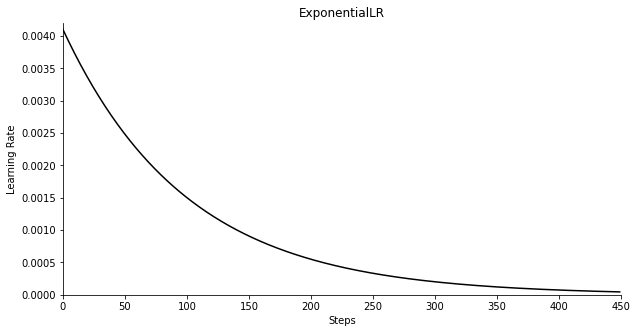

Mean and variance: (0.8591082692146301, nan)


In [ ]:
lr_values = []


########################################
#           Train and Eval             #
########################################

def main():
    # Initializing constants for the whole run.
    net_ema = None ## Reset any existing network emas, we want to have _something_ to check for existence so we can initialize the EMA right from where the network is during training
                   ## (as opposed to initializing the network_ema from the randomly-initialized starter network, then forcing it to play catch-up all of a sudden in the last several epochs)

    total_time_seconds = 0.
    current_steps = 0.

    # TODO: Doesn't currently account for partial epochs really (since we're not doing "real" epochs across the whole batchsize)....
    num_steps_per_epoch      = len(data['train']['images']) // batchsize
    total_train_steps        = num_steps_per_epoch * hyp['misc']['train_epochs']
    ema_epoch_start          = hyp['misc']['train_epochs'] - hyp['misc']['ema']['epochs']
    num_cooldown_before_freeze_steps = 0
    num_low_lr_steps_for_ema = hyp['misc']['ema']['epochs'] * num_steps_per_epoch

    ## I believe this wasn't logged, but the EMA update power is adjusted by being raised to the power of the number of "every n" steps
    ## to somewhat accomodate for whatever the expected information intake rate is. The tradeoff I believe, though, is that this is to some degree noisier as we
    ## are intaking fewer samples of our distribution-over-time, with a higher individual weight each. This can be good or bad depending upon what we want.
    projected_ema_decay_val  = hyp['misc']['ema']['decay_base'] ** hyp['misc']['ema']['every_n_steps']

    # Adjust pct_start based upon how many epochs we need to finetune the ema at a low lr for
    pct_start = hyp['opt']['percent_start'] #* (total_train_steps/(total_train_steps - num_low_lr_steps_for_ema))

    # Get network
    net = make_net()

    ## Stowing the creation of these into a helper function to make things a bit more readable....
    non_bias_params, bias_params = init_split_parameter_dictionaries(net)

    # One optimizer for the regular network, and one for the biases. This allows us to use the superconvergence onecycle training policy for our networks....
    opt = torch.optim.SGD(**non_bias_params)
    opt_bias = torch.optim.SGD(**bias_params)

    ## Not the most intuitive, but this basically takes us from ~0 to max_lr at the point pct_start, then down to .1 * max_lr at the end (since 1e16 * 1e-15 = .1 --
    ##   This quirk is because the final lr value is calculated from the starting lr value and not from the maximum lr value set during training)
    initial_div_factor = 1e16 # basically to make the initial lr ~0 or so :D

    ########################################
    #           Define LR Sched            #
    ########################################
    # lr_sched = torch.optim.lr_scheduler.OneCycleLR(opt,  max_lr=non_bias_params['lr'], pct_start=pct_start, div_factor=initial_div_factor, final_div_factor=1./(initial_div_factor*1e-24), total_steps=total_train_steps, anneal_strategy='linear', cycle_momentum=False)
    # lr_sched = torch.optim.lr_scheduler.OneCycleLR(opt,  max_lr=non_bias_params['lr'], pct_start=pct_start, div_factor=initial_div_factor, final_div_factor=1./(initial_div_factor*1e-24), total_steps=total_train_steps, anneal_strategy='cos', cycle_momentum=False)
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(opt,gamma = 0.99)
    # lr_sched      = torch.optim.lr_scheduler.CyclicLR(opt,base_lr = 0.0001, max_lr = 1e-3, step_size_up = 4, mode = "triangular")
    # lr_sched      = torch.optim.lr_scheduler.CyclicLR(opt,base_lr = 0.0001, max_lr = 1e-3, step_size_up = 4, mode = "triangular2")
    # lr_sched      = torch.optim.lr_scheduler.CyclicLR(opt,base_lr = 0.0001, max_lr = 1e-3, step_size_up = 4, mode = "exp-range")
    
    lr_sched_bias = torch.optim.lr_scheduler.OneCycleLR(opt_bias, max_lr=bias_params['lr'], pct_start=pct_start, div_factor=initial_div_factor, final_div_factor=1./(initial_div_factor*1e-24), total_steps=total_train_steps, anneal_strategy='linear', cycle_momentum=False)

    ## For accurately timing GPU code
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    torch.cuda.synchronize() ## clean up any pre-net setup operations


    # Get learning rates as each training step


    if True: ## Sometimes we need a conditional/for loop here, this is placed to save the trouble of needing to indent
        for epoch in range(hyp['misc']['train_epochs']):
          #################
          # Training Mode #
          #################
          torch.cuda.synchronize()
          starter.record()
          net.train()

          loss_train = None
          accuracy_train = None

          for epoch_step, (inputs, targets) in enumerate(get_batches(data, key='train', batchsize=batchsize)):
              ## Run everything through the network
              outputs = net(inputs)
              
              loss_batchsize_scaler = 512/batchsize # to scale to keep things at a relatively similar amount of regularization when we change our batchsize since we're summing over the whole batch
              ## If you want to add other losses or hack around with the loss, you can do that here.
              loss = loss_fn(outputs, targets).mul(hyp['opt']['loss_scale_scaler']*loss_batchsize_scaler).sum().div(hyp['opt']['loss_scale_scaler']) ## Note, as noted in the original blog posts, the summing here does a kind of loss scaling
                                                     ## (and is thus batchsize dependent as a result). This can be somewhat good or bad, depending...

              # we only take the last-saved accs and losses from train
              if epoch_step % 50 == 0:
                  train_acc = (outputs.detach().argmax(-1) == targets).float().mean().item()
                  train_loss = loss.detach().cpu().item()/(batchsize*loss_batchsize_scaler)

              loss.backward()

              ## Step for each optimizer, in turn.
              opt.step()
              opt_bias.step()

              lr_values.append(opt.param_groups[0]["lr"])

              # We only want to step the lr_schedulers while we have training steps to consume. Otherwise we get a not-so-friendly error from PyTorch
              lr_sched.step()
              lr_sched_bias.step()

              ## Using 'set_to_none' I believe is slightly faster (albeit riskier w/ funky gradient update workflows) than under the default 'set to zero' method
              opt.zero_grad(set_to_none=True)
              opt_bias.zero_grad(set_to_none=True)
              current_steps += 1

              if epoch >= ema_epoch_start and current_steps % hyp['misc']['ema']['every_n_steps'] == 0:          
                  ## Initialize the ema from the network at this point in time if it does not already exist.... :D
                  if net_ema is None or epoch_step < num_cooldown_before_freeze_steps: # don't snapshot the network yet if so!
                      net_ema = NetworkEMA(net, decay=projected_ema_decay_val)
                      continue
                  net_ema.update(net)
          ender.record()
          torch.cuda.synchronize()
          total_time_seconds += 1e-3 * starter.elapsed_time(ender)



          ####################
          # Evaluation  Mode #
          ####################
          net.eval()

          eval_batchsize = 785
          assert data['eval']['images'].shape[0] % eval_batchsize == 0, "Error: The eval batchsize must evenly divide the eval dataset (for now, we don't have drop_remainder implemented yet)."
          loss_list_val, acc_list, acc_list_ema = [], [], []
          
          with torch.no_grad():
              for inputs, targets in get_batches(data, key='eval', batchsize=eval_batchsize):
                  if epoch >= ema_epoch_start:
                      outputs = net_ema(inputs)
                      acc_list_ema.append((outputs.argmax(-1) == targets).float().mean())
                  outputs = net(inputs)
                  loss_list_val.append(loss_fn(outputs, targets).float().mean())
                  acc_list.append((outputs.argmax(-1) == targets).float().mean())
                  
              val_acc = torch.stack(acc_list).mean().item()
              ema_val_acc = None
              # TODO: We can fuse these two operations (just above and below) all-together like :D :))))
              if epoch >= ema_epoch_start:
                  ema_val_acc = torch.stack(acc_list_ema).mean().item()

              val_loss = torch.stack(loss_list_val).mean().item()
          # We basically need to look up local variables by name so we can have the names, so we can pad to the proper column width.
          ## Printing stuff in the terminal can get tricky and this used to use an outside library, but some of the required stuff seemed even
          ## more heinous than this, unfortunately. So we switched to the "more simple" version of this!
          format_for_table = lambda x, locals: (f"{locals[x]}".rjust(len(x))) \
                                                    if type(locals[x]) == int else "{:0.4f}".format(locals[x]).rjust(len(x)) \
                                                if locals[x] is not None \
                                                else " "*len(x)

          # Print out our training details (sorry for the complexity, the whole logging business here is a bit of a hot mess once the columns need to be aligned and such....)
          ## We also check to see if we're in our final epoch so we can print the 'bottom' of the table for each round.
          print_training_details(list(map(partial(format_for_table, locals=locals()), logging_columns_list)), is_final_entry=(epoch == hyp['misc']['train_epochs'] - 1))
    

        # Visualize learinig rate scheduler
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        ax.plot(range(len(lr_values)), lr_values,color='black',label="Learning Rate")
        ax.set_xlim([0, len(lr_values)])
        ax.set_ylim([0,max(lr_values) + 0.0001])
        ax.set_xlabel('Steps')
        ax.set_ylabel('Learning Rate')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(label='ExponentialLR')
        plt.show()
    
    return val_acc # Return the final non-ema accuracy achieved (not using the 'best accuracy' selection strategy, which I think is okay here....)
                   # Note: For longer runs with much larer models, you may want to switch to the 'val_ema_acc' metric. This is because
                   # that metric does much better outside of these extremely rapid training runs.

print_training_details(logging_columns_list, column_heads_only=True) ## print out the training column heads before we print the actual content for each run.


if __name__ == "__main__":
    acc_list = []
    for run_num in range(1):
        acc_list.append(torch.tensor(main()))
    print("Mean and variance:", (torch.mean(torch.stack(acc_list)).item(), torch.var(torch.stack(acc_list)).item()))